In [49]:
# Importing necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Load the data from the provided CSV file
file_path = 'train (1).csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA and Initial data cleaning

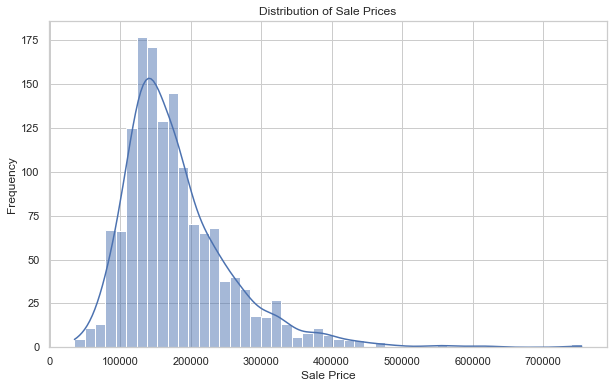

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [50]:
# Importing necessary libraries for EDA and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setting aesthetics for plots
sns.set(style="whitegrid")

# Summary statistics of the dataset
summary = data.describe()

# Checking for missing values
missing_values = data.isnull().sum()

# Plotting the distribution of SalePrice (target variable)
plt.figure(figsize=(10,6))
sns.histplot(data['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

# Displaying summary statistics and top missing values
print(summary)
print(missing_values.sort_values(ascending=False).head(20))

# Data cleaning

In [51]:
# Handle missing values
# For simplicity, let's remove features with a high percentage of missing values and impute others
high_missing = missing_values[missing_values > data.shape[0]*0.5].index
data_cleaned = data.drop(high_missing, axis=1)

# Imputing missing values for the rest with median/mode
for column in data_cleaned.columns:
    if data_cleaned[column].dtype == 'object':
        data_cleaned[column].fillna(data_cleaned[column].mode()[0], inplace=True)
    else:
        data_cleaned[column].fillna(data_cleaned[column].median(), inplace=True)

# Check for any remaining missing values
missing_after_cleaning = data_cleaned.isnull().sum().max()

# Treat Outliers (example using IQR)
Q1 = data_cleaned.quantile(0.25)
Q3 = data_cleaned.quantile(0.75)
IQR = Q3 - Q1

# Removing outliers
data_cleaned = data_cleaned[~((data_cleaned < (Q1 - 1.5 * IQR)) |(data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]


C:\Users\tejag\AppData\Local\Temp\ipykernel_29156\2396838067.py:22: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data_cleaned = data_cleaned[~((data_cleaned < (Q1 - 1.5 * IQR)) |(data_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]


# Feature Engineering

In [52]:
# Encoding categorical variables using One-Hot Encoding
data_encoded = pd.get_dummies(data_cleaned, drop_first=True)

# Preparation for modelling

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting the data into features and target variable
X = data_encoded.drop('SalePrice', axis=1)
y = data_encoded['SalePrice']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features (important for models like Ridge and Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model building

# Ridge regression

In [54]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Ridge regression model
ridge = Ridge()

# Parameters to search
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Using GridSearchCV to find the optimal alpha
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train_scaled, y_train)

# Best parameter and score
ridge_best_params = ridge_regressor.best_params_
ridge_best_score = ridge_regressor.best_score_

# Lasso regression

In [55]:
# Lasso regression model
lasso = Lasso()

# Using GridSearchCV to find the optimal alpha
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train_scaled, y_train)

# Best parameter and score
lasso_best_params = lasso_regressor.best_params_
lasso_best_score = lasso_regressor.best_score_

C:\Users\tejag\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e+10, tolerance: 1.117e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\tejag\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e+10, tolerance: 1.091e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\tejag\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e+10, toleranc

# Model Evaluation

In [56]:
from sklearn.metrics import r2_score, mean_squared_error

# Predicting and evaluating Ridge
ridge_pred = ridge_regressor.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)

# Predicting and evaluating Lasso
lasso_pred = lasso_regressor.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)

In [57]:
print("Ridge Regression")
print("Best Alpha:", ridge_best_params)
print("R2 Score:", ridge_r2)
print("MSE:", ridge_mse)

print("\nLasso Regression")
print("Best Alpha:", lasso_best_params)
print("R2 Score:", lasso_r2)
print("MSE:", lasso_mse)

Ridge Regression
Best Alpha: {'alpha': 20}
R2 Score: 0.8873948490792368
MSE: 318462687.95008975

Lasso Regression
Best Alpha: {'alpha': 20}
R2 Score: 0.8831357473885779
MSE: 330508007.0280281


# model looks decent

# Question 1

In [58]:
# Doubling the alpha for Ridge and Lasso
new_alpha = 40

# Fitting Ridge with the new alpha
new_ridge = Ridge(alpha=new_alpha)
new_ridge.fit(X_train_scaled, y_train)

# Fitting Lasso with the new alpha
new_lasso = Lasso(alpha=new_alpha)
new_lasso.fit(X_train_scaled, y_train)

# Extracting the most important features for Ridge
ridge_coefficients = pd.Series(new_ridge.coef_, index=X.columns)
ridge_important = ridge_coefficients.abs().sort_values(ascending=False).head()

# Extracting the most important features for Lasso
lasso_coefficients = pd.Series(new_lasso.coef_, index=X.columns)
lasso_important = lasso_coefficients[lasso_coefficients != 0].abs().sort_values(ascending=False).head()

ridge_important, lasso_important

(GrLivArea      9351.028355
 OverallQual    6567.082052
 2ndFlrSF       6158.695984
 GarageArea     5728.794263
 BsmtQual_Gd    5500.555231
 dtype: float64,
 GrLivArea         16990.029317
 2ndFlrSF          11625.916448
 KitchenQual_TA     9697.625582
 KitchenQual_Gd     9381.694186
 BsmtFinSF1         7442.625400
 dtype: float64)

# Question2

In [59]:
# Ridge Regression with optimal alpha
optimal_ridge = Ridge(alpha=20)
optimal_ridge.fit(X_train_scaled, y_train)
# Lasso Regression with optimal alpha
optimal_lasso = Lasso(alpha=20)
optimal_lasso.fit(X_train_scaled, y_train)

Lasso(alpha=20)

In [60]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions
ridge_predictions = optimal_ridge.predict(X_test_scaled)
lasso_predictions = optimal_lasso.predict(X_test_scaled)

# Evaluating Ridge Regression
ridge_r2 = r2_score(y_test, ridge_predictions)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

# Evaluating Lasso Regression
lasso_r2 = r2_score(y_test, lasso_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Print the performance
print("Ridge Regression Performance:")
print("R2 Score:", ridge_r2)
print("MSE:", ridge_mse)

print("\nLasso Regression Performance:")
print("R2 Score:", lasso_r2)
print("MSE:", lasso_mse)


Ridge Regression Performance:
R2 Score: 0.8873948490792368
MSE: 318462687.95008975

Lasso Regression Performance:
R2 Score: 0.8831357473885779
MSE: 330508007.0280281


# Question3

In [61]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Now, drop the top 5 predictors from these DataFrames
X_train_reduced = X_train_df.drop(columns=top_5_predictors, axis=1)
X_test_reduced = X_test_df.drop(columns=top_5_predictors, axis=1)

In [62]:
new_lasso = Lasso(alpha=20)
new_lasso.fit(X_train_reduced, y_train)

Lasso(alpha=20)

In [63]:
# Extract the coefficients of the new Lasso model
new_lasso_coefficients = pd.Series(new_lasso.coef_, index=X_train_reduced.columns)

# Identify the top 5 predictors from the new model
new_top_5_predictors = new_lasso_coefficients.abs().sort_values(ascending=False).head(5).index

# Print the new top 5 predictors
print("The five most important predictor variables now are:", new_top_5_predictors)


The five most important predictor variables now are: Index(['BsmtQual_Gd', 'HouseStyle_1Story', 'GarageArea', 'BsmtQual_TA',
       'TotalBsmtSF'],
      dtype='object')
